## Experiments in analyzing tracking data (and maybe other sensors data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
tracking_data = pd.read_csv('test_results/result_1.csv')
tracking_data.head()

,frame,x,y
0,2,124,32
1,3,124,32
2,4,124,32
3,5,124,32
4,6,124,34


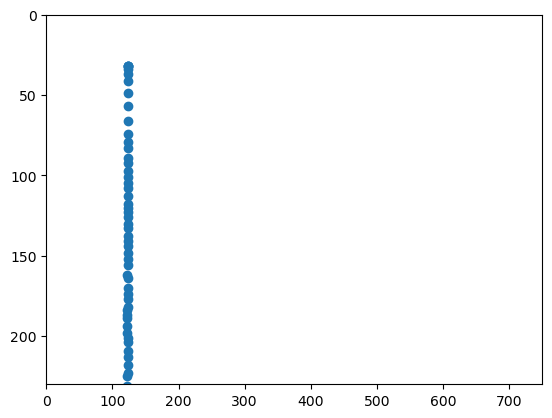

In [3]:
#plotting the data as a scatter plot
plt.scatter(tracking_data['x'], tracking_data['y'])
#set axis max and min
plt.xlim(0, 750)
plt.ylim(0, 230)
#flip the y-axis to make it right-side-up
plt.gca().invert_yaxis()
plt.show()

In [4]:
#convert frames to seconds
fps = 29
time = tracking_data['frame']/fps


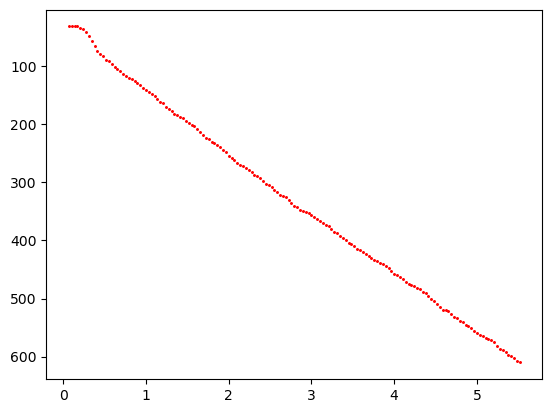

In [5]:
#plot x as a function of time
plt.gca().invert_yaxis()
plt.scatter(time, tracking_data['y'], c='r', marker='.', s=5)

Text(0, 0.5, 'Velocity (pixels/s)')

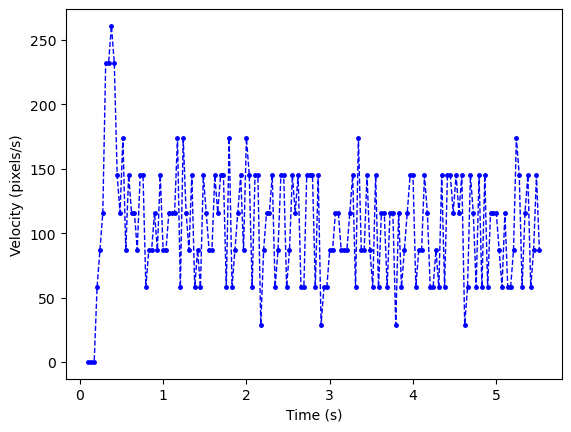

In [17]:
#calculate y velocity
y_vel = np.diff(tracking_data['y'])/np.diff(time)
#plot y velocity as a function of time
plt.plot(time[1:], y_vel, c='b', marker='.', ms=5, linestyle='dashed', linewidth=1)
#add axis labels
plt.xlabel('Time (s)')
plt.ylabel('Velocity (pixels/s)')

In [21]:
test_speed = y_vel[30::]
mean_speed = np.mean(test_speed)
mean_dv_st = np.std(test_speed)/np.sqrt(len(test_speed))
print(mean_speed)
print(mean_dv_st)
print(np.std(test_speed))

103.765625
3.400089116892033
38.46761713908698


## Trying to solve the difraction problem
We use the blue lines on the cilinder to compute a gradient and then transform the frame to make an ortogonal projection

In [40]:
import cv2

TypeError: Image data of dtype object cannot be converted to float

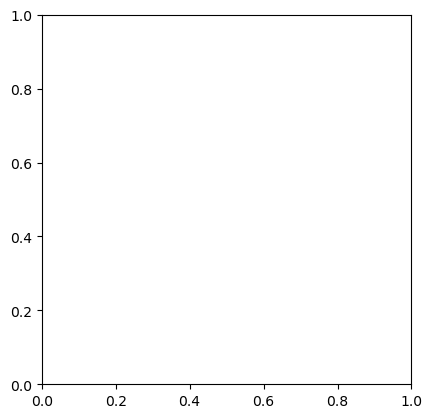

In [41]:
#get a frame from webcam

cap = cv2.VideoCapture(1)
ret, frame = cap.read()
cap.release()

#plot the frame
plt.imshow(frame)
plt.show()

#save the frame
cv2.imwrite('test_results/frame_refraction.png', frame)

In [42]:
def get_click_positions(frame):
    left_clicks = []
    right_clicks = []

    def click_event(event, x, y, flags, param):
        nonlocal left_clicks, right_clicks
        if event == cv2.EVENT_LBUTTONDOWN:
            left_clicks.append(y)
            cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            cv2.imshow('Frame', frame)
        elif event == cv2.EVENT_RBUTTONDOWN:
            right_clicks.append(y)
            cv2.circle(frame, (x, y), 3, (0, 255, 0), -1)
            cv2.imshow('Frame', frame)

    cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)
    aspect_ratio = frame.shape[1] / frame.shape[0]
    window_width = 1080
    window_height = int(window_width / aspect_ratio)
    cv2.resizeWindow('Frame', window_width, window_height)
    cv2.imshow('Frame', frame)
    cv2.setMouseCallback('Frame', click_event)

    while True:
        if cv2.waitKey(1) & 0xFF == ord('d'):
            break

    cv2.destroyAllWindows()
    return left_clicks, right_clicks #left is front right is back

In [43]:
frame = cv2.imread('test_results/frame_refraction.png')
front_pos_a, back_pos_a = get_click_positions(frame)

In [49]:
front_pos = front_pos_a.copy()
back_pos = (back_pos_a.copy())[:-1]

In [50]:
front_pos = front_pos[:-1]
print(front_pos)
print(back_pos)

[353, 327, 298, 271, 243, 215, 189, 162, 134, 108, 85]
[344, 320, 295, 271, 247, 222, 198, 173, 150, 125, 104]


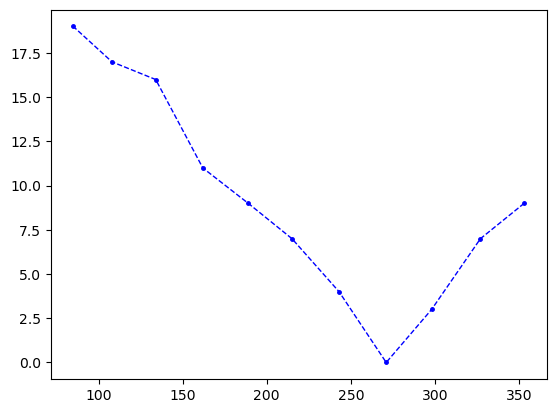

In [53]:
#compute absolute difference between front and back positions
diff = np.abs(np.array(front_pos) - np.array(back_pos))

mean_pos = [fp - bp for fp, bp in zip(front_pos, back_pos)]
plt.plot(front_pos, diff, c='b', marker='.', ms=5, linestyle='dashed', linewidth=1)


In [66]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import PolynomialFeatures

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_47 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 21        
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________
None
(11, 3)
(11,)
Epoch 1/1000
1/1 [==============================] - 0s 999us/step - loss: 71701152.0000
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 60888796.0000
Epoch 3/1000
1/1 [==============================] - 0s 980us/step - loss: 51002664.0000
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 42050992.0000
Epoch 5/1000
1/1 [

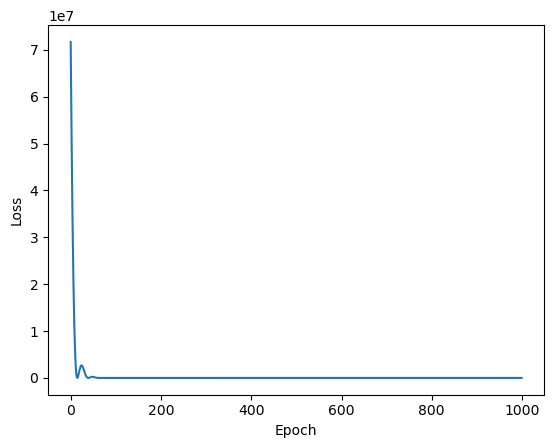

In [78]:
#fit the data with unknown function using a neural network
# Preparing data
x_data = np.array(front_pos)
y_data = np.array(diff)

# Polynomial feature expansion
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x_data.reshape(-1, 1))


x_input = np.concatenate((x_poly, x_exp.reshape(-1, 1)), axis=1)

# Define the neural network model
model = keras.Sequential([
    layers.Dense(units=20, activation='relu', input_shape=[x_poly.shape[1]]),
    layers.Dense(units=20, activation='relu'),
    layers.Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())
print(x_poly.shape)
print(y_data.shape)

# Train the model
model.fit(x_poly, y_data, epochs=1000)
#show loss curve and accuracy
plt.plot(model.history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

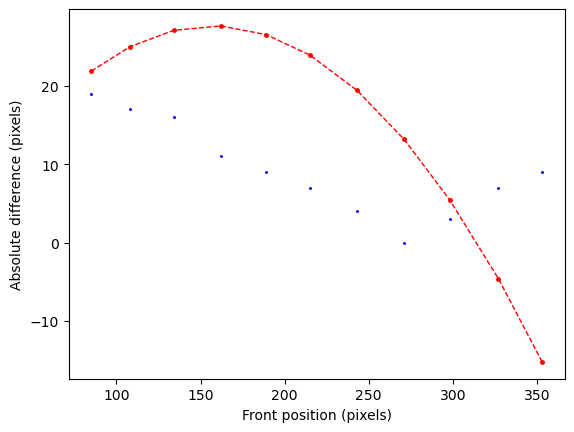

In [80]:
# Predict y values
y_pred = model.predict(x_poly)

# Plot the results
plt.scatter(x_data, y_data, c='b', marker='.', s=5)
plt.plot(x_data, y_pred, c='r', marker='.', ms=5, linestyle='dashed', linewidth=1)
plt.xlabel('Front position (pixels)')
plt.ylabel('Absolute difference (pixels)')
plt.show()

#### try with SVM

In [81]:
from sklearn.svm import SVR

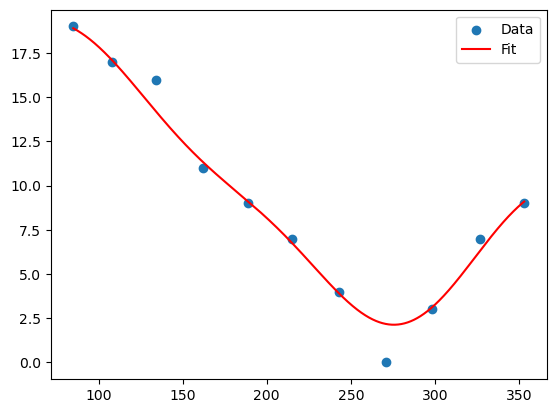

In [94]:
# Reshape data
x_data = x_data.reshape(-1, 1)
y_data = y_data.ravel()

# Create the SVR model with RBF kernel
model = SVR(kernel='rbf', C=100, gamma=0.0001, epsilon=.1)

# Fit the model
model.fit(x_data, y_data)

# Create a fine-grained grid to evaluate the model
x_grid = np.linspace(min(x_data), max(x_data), 1000).reshape(-1, 1)

# Predict y values
y_pred = model.predict(x_grid)

# Plot the data and the fit
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_grid, y_pred, label='Fit', color='red')
plt.legend()
plt.show()

## Trying to solve lens distortion but with poor results

In [2]:
def catch_close_contours(contours, min_dist = 100):
    to_remove = []
    for i in range(len(contours)):
        i_countur_area = cv2.contourArea(contours[i])
        try:
            i_countour_pos_x = cv2.moments(contours[i])["m10"] / cv2.moments(contours[i])["m00"]
            i_countour_pos_y = cv2.moments(contours[i])["m01"] / cv2.moments(contours[i])["m00"]
        except:
            continue
        for j in range(len(contours)):
            if i == j:
                continue
            j_countur_area = cv2.contourArea(contours[j])
            try:
                j_countour_pos_x = cv2.moments(contours[j])["m10"] / cv2.moments(contours[j])["m00"]
                j_countour_pos_y = cv2.moments(contours[j])["m01"] / cv2.moments(contours[j])["m00"]
            except:
                continue
            if np.sqrt((i_countour_pos_x - j_countour_pos_x)**2 + (i_countour_pos_y - j_countour_pos_y)**2) < 100:
                if i_countur_area > j_countur_area:
                    to_remove.append(j)
                else:
                    to_remove.append(i)
                break
    return to_remove

In [37]:
import copy

def remove_lens_distortion(frame):
    # Convert the image to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define range for black color
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 30])

    # Create a mask
    mask = cv2.inRange(hsv, lower_black, upper_black)

    #rectangular mask to remove left side of image
    mask[:, 0:100] = 0
    frame = cv2.bitwise_and(frame, frame, mask=mask)

    # Find the contours of the black dots
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #if two of the contours are too close together, remove the smaller one
    to_remove = catch_close_contours(contours)
    contours = [contours[i] for i in range(len(contours)) if i not in to_remove]
    
    # Maintain only the 4 largest contours
    contours_maxes = sorted(contours, key=cv2.contourArea, reverse=True)[:35]

    # Ensure we have found 4 dots
    if len(contours_maxes) != 35:
        print( "Error: Did not find 4 black dots")

    # Get the center coordinates of the dots and sort them based on their position
    centers = []
    for contour in contours_maxes:
        M = cv2.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append([cX, cY])
    
    centers = sorted(centers, key=lambda x: (x[1], x[0]))
    print(centers)

    # Define your object points here (the real-world coordinates of the dots)
    #obj_points = np.array([[0, 0, 0], [26, 0, 0], [0, 15, 0], [26, 15, 0]], dtype='float32')
    obj_points = np.array([
 [0, 0.0, 0], [4, 0.0, 0], [18, 0.0, 0], [22, 0.0, 0], [26, 0.0, 0], 
 [0, 2.5, 0], [4, 2.5, 0], [18, 2.5, 0], [22, 2.5, 0], [26, 2.5, 0], 
 [0, 5.0, 0], [4, 5.0, 0], [18, 5.0, 0], [22, 5.0, 0], [26, 5.0, 0], 
 [0, 7.5, 0], [4, 7.5, 0], [18, 7.5, 0], [22, 7.5, 0], [26, 7.5, 0], 
 [0, 10.0, 0], [4, 10.0, 0], [18, 10.0, 0], [22, 10.0, 0], [26, 10.0, 0], 
 [0, 12.5, 0], [4, 12.5, 0], [18, 12.5, 0], [22, 12.5, 0], [26, 12.5, 0], 
 [0, 15.0, 0], [4, 15.0, 0], [18, 15.0, 0], [22, 15.0, 0], [26, 15.0, 0]
]

, dtype='float32')
    
    # Reshape centers array and obj_points for calibration (shape s)
    img_points = np.array(centers, dtype='float32').reshape(-1, 1, 2)
    obj_points = obj_points.reshape(-1, 1, 3)


    # Get image size
    h, w = frame.shape[:2]

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([obj_points], [img_points], (w, h), None, None)
    print("mtx: ")
    print(mtx)
    print("\n")
    print("dist: ")
    print(dist)
    print("\n")
    print("rvecs: ")
    print(rvecs)
    print("\n")
    print("tvecs: ")
    print(tvecs)
    print("\n")

    #new camera matrix
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

    # Remove distortion
    undistorted_img = cv2.undistort(frame, mtx, dist, None, newcameramtx)
    
    return undistorted_img, centers


In [75]:
#get a frame from webcam
cap = cv2.VideoCapture(1)
ret, dist_frame = cap.read()
cap.release()

#save the frame
cv2.imwrite('test_results/frame_distortion.png', dist_frame)

True

In [39]:
dist_frame = cv2.imread('test_results/frame_distortion_bk.png')
test_udistorted, centers = remove_lens_distortion(dist_frame)

#test_udistorted conains center of tracked dots, add circle to image
#for center in centers:
#    random_color = np.random.randint(0, 255, 3).tolist()
#    cv2.circle(dist_frame, (int(center[0]), int(center[1])), 5, random_color, -1)

#plot the frame
#plt.imshow(dist_frame)

#Show the original and undistorted images (make plot bigger)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(dist_frame)
centers_x = [center[0] for center in centers]
centers_y = [center[1] for center in centers]
plt.scatter(centers_x, centers_y, c='r', marker='.', s=5)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(test_udistorted)
plt.title('Undistorted')

ZeroDivisionError: float division by zero

In [26]:
def correct_lens_distortion(frame):
    h, w = frame.shape[:2]

    # Assuming the intrinsic matrix is the identity matrix; you might want to replace it with the actual camera matrix after calibration
    camera_matrix = np.array([[w/2, 0, w/2], [0, h/2, h/2], [0, 0, 1]])

    # Default distortion coefficients; replace with actual values after calibration
    dist_coeffs = np.array([-3.29722417e-03, -2.33878178e-04, -1.22417204e-02, -1.13626711e-03, -1.62650235e-05])

    undistorted_frame = cv2.undistort(frame, camera_matrix, dist_coeffs)

    return undistorted_frame

Text(0.5, 1.0, 'Undistorted')

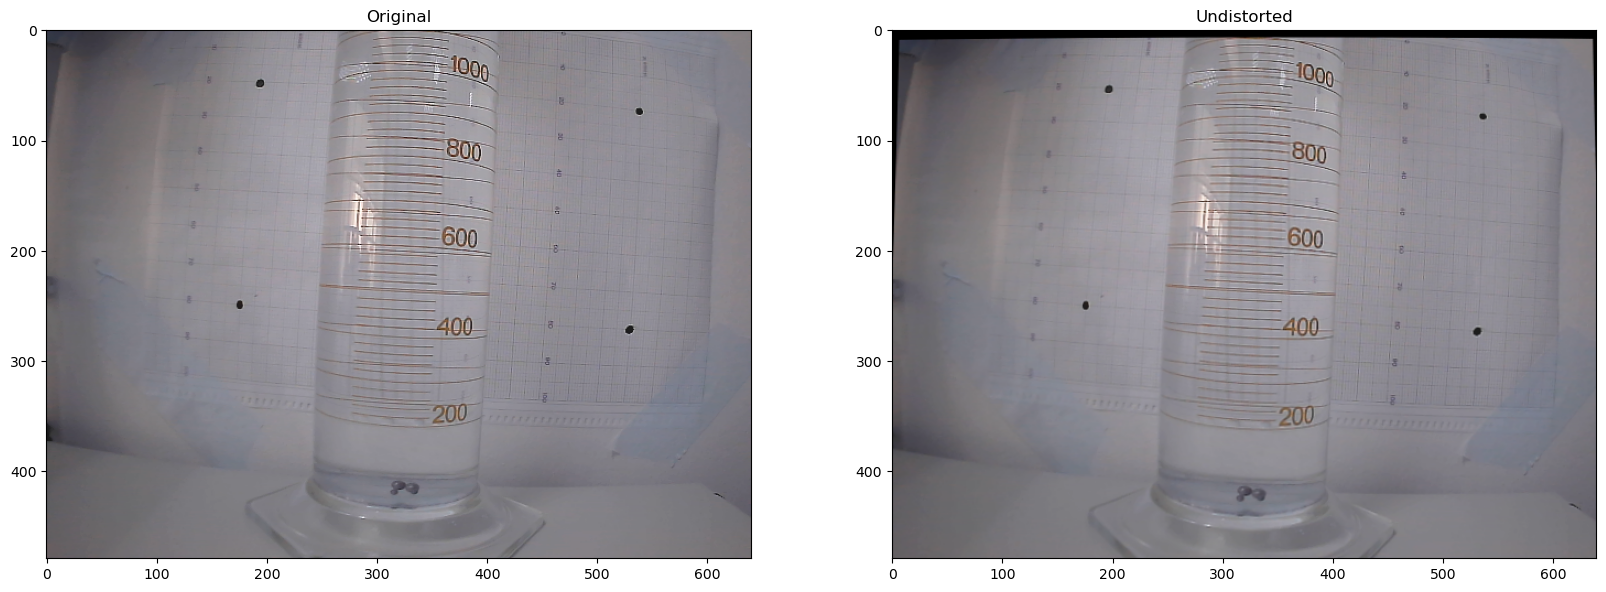

In [27]:
dist_frame = cv2.imread('test_results/frame_distortion.png')
test2_udistorted = correct_lens_distortion(dist_frame)

#Show the original and undistorted images (make plot bigger)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(dist_frame)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(test2_udistorted)
plt.title('Undistorted')

### correct lens distortion with parameters calculated wit ChArUco

In [ ]:
import pandas as pd

In [ ]:
camera = 'expwebcam'
frame_d = cv2.imread('test_results/frame_distortion.png')

#load camera configs
cameras_configs = pd.read_csv('configs/cameras_config.csv')
camera_config = cameras_configs[cameras_configs['camera'] == camera]
ret, camera_matrix, dist_coeffs, rvecs, tvecs = camera_config

#undistort frame
frame_u = cv2.undistort(frame_d, camera_matrix, dist_coeffs)

#show image
plt.imshow(frame_u)

### lets try do do automatic blue lines detection

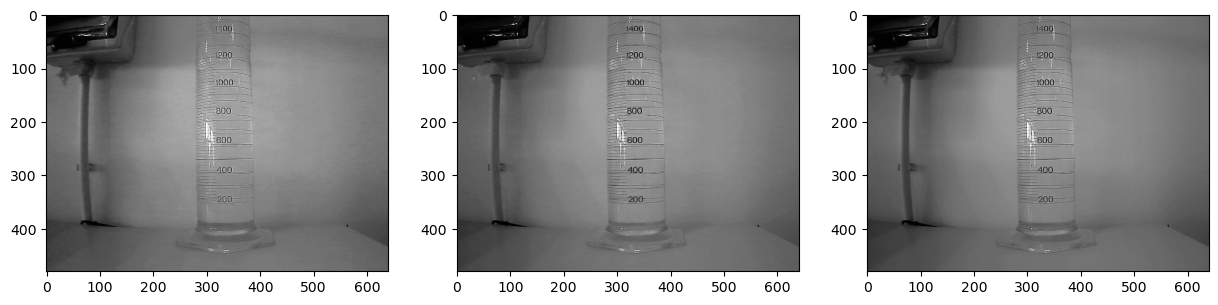

In [73]:
frame_line = cv2.imread('test_results/frame_refraction.png')
#isolate blue channel
blue_channel = frame_line[:, :, 0]
red_channel = frame_line[:, :, 2]
green_channel = frame_line[:, :, 1]

#subplot with 3 plots: blue, red, green
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(blue_channel, cmap='gray')
ax[1].imshow(red_channel, cmap='gray')
ax[2].imshow(green_channel, cmap='gray')